# 03: Identifying Power Outages Using Social Media - Exploratory Data Analysis
### Danielle Medellin, Matthew Malone, Omar Smiley

## Table of Contents
- [Import Libraries](#Import-Libraries)
- [Load Data](#Load-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Outage Sentiment](#Exploring-outage_sentiment)
    - [Outage Sentiment and State](#Exploring-outage_sentiment-by-State)
- [Count Vectorizer](#CountVectorizer)
- [Word2Vec Model](#Word2Vec-Model)
    - [Results: Word Associations](#Words-most-and-least-associated-with-search_terms)
- [Outage Sentiment Analysis](#Outage-Sentiment-Analysis)
- [Next Steps](#Next-Steps)

## Import Libraries 

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [61]:
tweets = pd.read_csv('../data/cleaned_tweets.csv')

In [62]:
tweets.head()

,tweet_id,username,text,tweet_date,search_term,city,lat,long,radius,query_start,name_and_tweet,outage_sentiment,state
0,710245730590404608,ttwn sf bay area,power outage in cupertino bayarea traffic,2016-03-16 23:25:52,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,ttwn sf bay area power outage in cupertino bay...,0.33,California
1,708811502241734656,san jose now,weather alert flash flood watch in bay area am...,2016-03-13 00:26:45,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now weather alert flash flood watch i...,0.25,California
2,706856719733776384,san jose now,power outages in san francisco on peninsula in...,2016-03-07 14:59:09,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now power outages in san francisco on...,0.18,California
3,726876023573204993,san jose now,power outage in fremont several intersections ...,2016-05-01 20:48:43,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now power outage in fremont several i...,0.23,California
4,724681945095888897,san jose now,east bay power outages also affects bart uc be...,2016-04-25 19:30:14,power outage,San Jose,37.3323,-121.853394,10mi,2016-01-01,san jose now east bay power outages also affec...,0.20,California


In [63]:
tweets.shape

(16913, 13)

In [64]:
tweets.dtypes

tweet_id              int64
username             object
text                 object
tweet_date           object
search_term          object
city                 object
lat                 float64
long                float64
radius               object
query_start          object
name_and_tweet       object
outage_sentiment    float64
state                object
dtype: object

In [65]:
tweets['tweet_date'] = pd.to_datetime(tweets['tweet_date'])

## Exploratory Data Analysis

In [66]:
tweets['outage_sentiment'].describe()

count    16913.000000
mean         0.124359
std          0.096824
min          0.000000
25%          0.060000
50%          0.100000
75%          0.170000
max          1.000000
Name: outage_sentiment, dtype: float64

The minimum outage sentiment is 0 while the max is 1. The mean is .124, showing that there is a low average outage sentiment. The 75th percentile is below .2 showing that the overwhelming majority of the tweets have low proportions of words that are associationed with power outages.  

### Exploring `outage_sentiment`

In [67]:
tweets[tweets['outage_sentiment']==1]['text']

5315                                          power outage
13649                                    this power outage
14876    storm update cps reports there are currently  ...
Name: text, dtype: object

The first two tweets in this list obviously have high association with power outages because that is literally all the tweet says. It makes sense for these tweets to have an outage sentiment value of 1. 

In [68]:
tweets.loc[14876,['text']][0]

'storm update cps reports there are currently  power outages affecting  customers in the san antonio area'

Looking at the final tweet with an outage sentiment of 1, we see a tweet that is explicitly describing a power outage in a specific area due to a storm. It, again, makes sense that this tweet would have an outage sentiment of 1 and is a great example of a tweet that would give information about a power outage. 

In [69]:
len(tweets[tweets['outage_sentiment']==0]['text'])

815

There are 815 tweets in the data set that received an outage sentiment score of 0. This means they are expected to have absoluetly no association with power outages. We will spot check a few of these tweets.

In [70]:
tweets.loc[335,['name_and_tweet']][0]

'carmen garsia here at the movies to see lightsout they werent kidding where are'

The above tweet has the phrase `lightsout` which was part of the search terms that we looked for in our intial scrape. We noticed that this pulled in many tweets about a horror movie, Lights Out, that came out in 2016. For this reason, we removed `lightsout` from our association list and, correctly, identified that tweets like the one above don't actually have any association with a power outage. 

In [71]:
tweets.loc[1738,['name_and_tweet']][0]

'pahblow i got bills theyre multiplying and im loosing controlcause the powerthey supplyingis gonna get cut off if i dont get my shit together'

The tweet above was pulled into our dataset because of its use of the word `power` and `cut` which were search terms. But after closer analysis of the tweet, we can see the tweet doesn't actually have anything to a power outage, despite the user discussing their power supply and it possibly being shut off. 

In [72]:
tweets.loc[16781,['name_and_tweet']][0]

'performance course incredible week of work for hpscotsbaseball capped off by an electric competition daycompete in preparation dominate in performanceso to our s of the week the legend drake  homerun sterling   at highland park high school'

The above tweet was pulled into our dataset for its use of the word `electric`, but obviously has nothing to do with power outages or electricity. It is valid that this tweet has an outage sentiment of 0. 

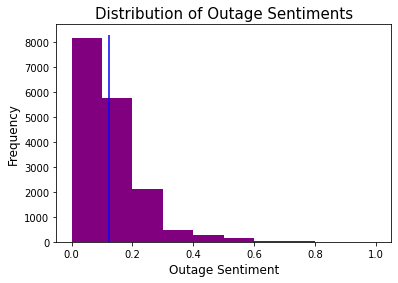

In [103]:
plt.hist(tweets['outage_sentiment'],color='purple')
plt.title('Distribution of Outage Sentiments', size = 15)
plt.xlabel('Outage Sentiment', size=12)
plt.ylabel('Frequency',size=12)
plt.vlines(x=tweets['outage_sentiment'].mean(),ymin=0, ymax=8300,color='blue');

Above is the distribution of outage sentiment values for all tweets. The data is right skewed with a majority of the data falling below 0.2. The mean falls just above 0.1. As outage sentiment increases, the amount of tweets with that value decreases. Most of the tweets we found did not have strong associations to power outages. 

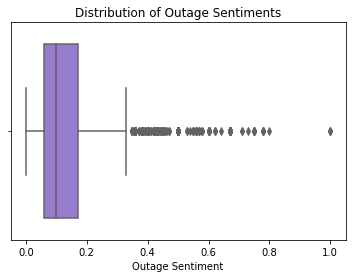

In [117]:
boxplot = sns.boxplot(tweets['outage_sentiment'],color='mediumpurple')
boxplot.set(xlabel='Outage Sentiment',title='Distribution of Outage Sentiments');

Again, we see that the majority of the data has a low outage sentiment value. As the outage sentiment value increases, the amount of tweets with that value decreases. Based on what we have observed, a tweet with an outage sentiment value of .3 or above should qualify as as valid tweet discussing a power outage. 

### Exploring `outage_sentiment` by State

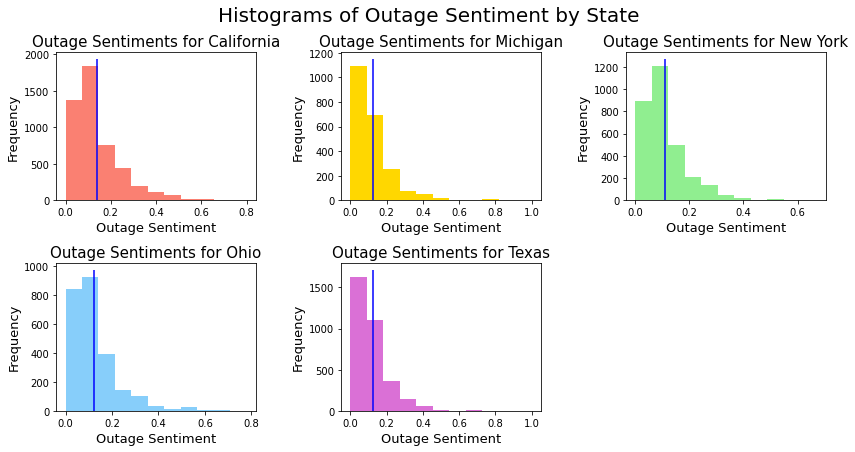

In [114]:
cols = ['California','Michigan','New York','Ohio','Texas']

fig, axes = plt.subplots(figsize = (12,6), ncols = 3, nrows= 2)

fig.suptitle("Histograms of Outage Sentiment by State", fontsize = 20, y = 1.04) # y is percentage of figure height for placement

axes = axes.flatten()

color = ['salmon', 'gold','lightgreen','lightskyblue','orchid']

for i, col in enumerate(cols):
    ax = axes[i]
    ax.hist(tweets[tweets['state']==col]['outage_sentiment'],color=color[i],bins=11)
    ax.set_ylabel("Frequency",size=13)
    ax.set_xlabel('Outage Sentiment',size=13)
    ax.set_title(f"Outage Sentiments for {col}",size=15)
    y_min, y_max = ax.get_ylim()
    ax.vlines(x=tweets[tweets['state']==col]['outage_sentiment'].mean(),ymin=0, ymax=y_max,color='blue')
    

axes[5].set_visible(False)

plt.tight_layout();

All five states had right skewed data with their peaks landing around a 0.1 outage sentiment. Means for each distribution are shown with a blue line, and all fall between 0.1 and 0.2. 

In [91]:
states = tweets['state'].value_counts().index

In [92]:
tweets.groupby('state')['outage_sentiment'].mean()

state
California    0.137524
Michigan      0.127387
New York      0.110815
Ohio          0.124441
Texas         0.122096
Name: outage_sentiment, dtype: float64

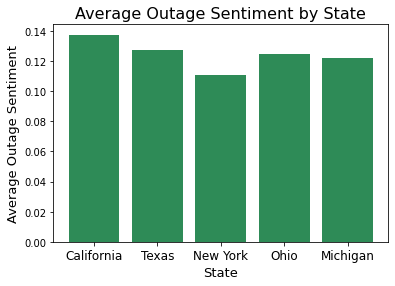

In [97]:
plt.bar(states,tweets.groupby('state')['outage_sentiment'].mean(), color = 'seagreen')
plt.title('Average Outage Sentiment by State',size=16)
plt.xlabel('State',size=13)
plt.ylabel('Average Outage Sentiment',size=13)
plt.xticks(size=12);

There was not a ton of variation in the average outage sentiment gathered by state. California had the highest average outage sentiment, but also had the most amount of data collected. New York had the lower average outage sentiment. All average outage sentiments landed between .10 and .14